In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
image_dir = "cropped/"
images = [os.path.join(image_dir, image) for image in os.listdir(image_dir)]
images[:2]

['cropped/10009_2004.jpg', 'cropped/10032_2004.jpg']

In [3]:
# preprocess
image_size = 64

def preprocess(image):
    
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image) #img to tensor
    image = tf.cast(image, tf.float32) #convert to float32
    image = tf.image.resize(image, (image_size, image_size)) 
    image = image / 255.0
    image = tf.reshape(image, shape = (image_size, image_size, 3,))
    return image

In [4]:
batch_size = 128

training_dataset = tf.data.Dataset.from_tensor_slices((images))# it creates a dataset from the list of image file paths stored in the images variable.
training_dataset = training_dataset.map(preprocess) # this takes one datapoint from tensor and pass it through prepocess function
training_dataset = training_dataset.shuffle(1000).batch(batch_size)# to inc randomization in the dataset

In [5]:
len(training_dataset)

241

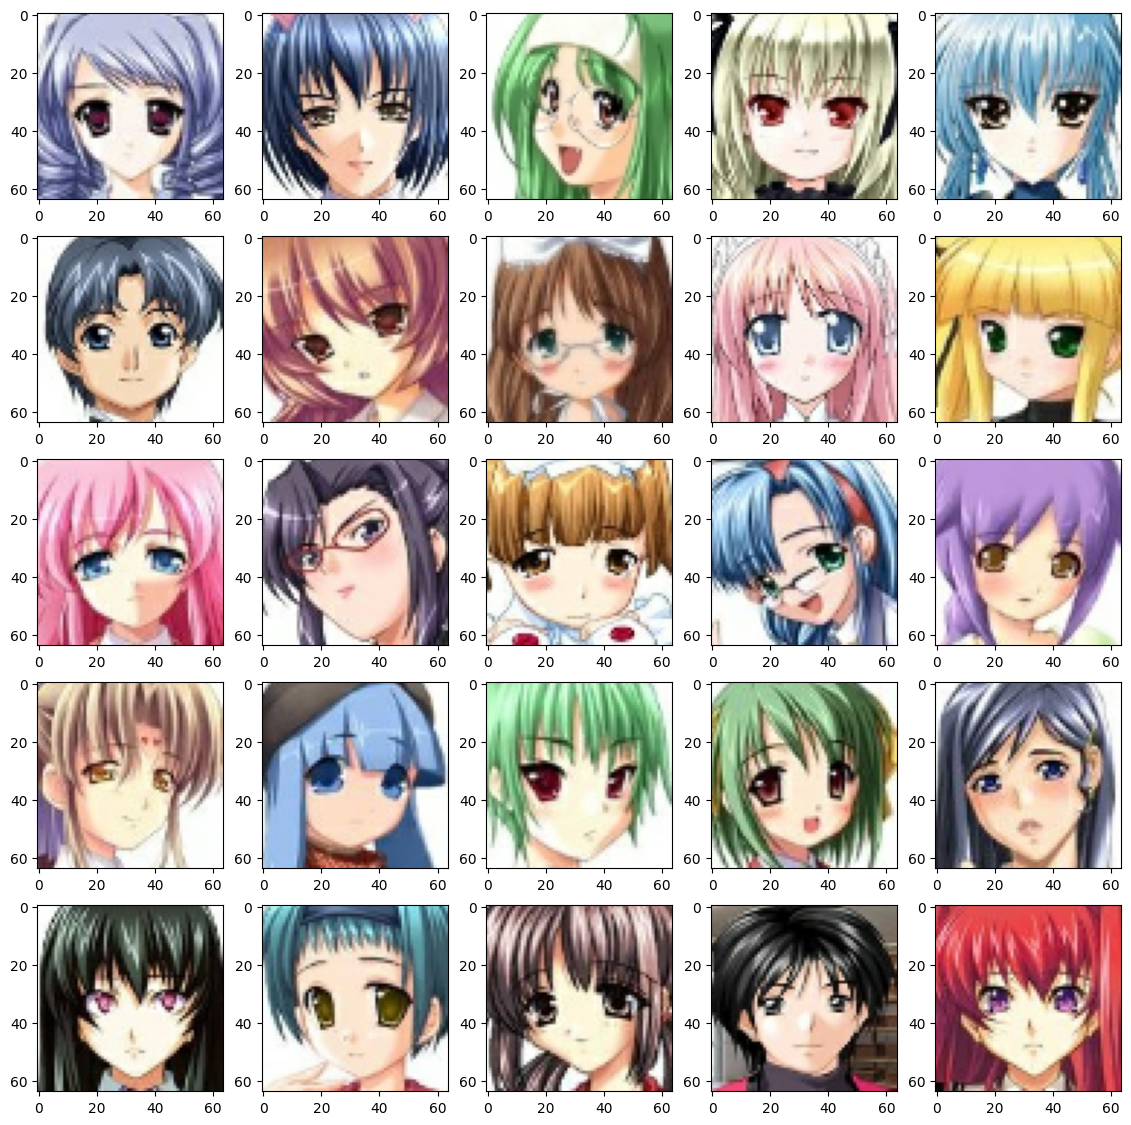

In [6]:
# visualize some of them
fig, axes = plt.subplots(5,5, figsize = (14,14))
sample = training_dataset.unbatch().take(25)# takes out first 25 images from the dataset
sample = [image for image in sample] #converts the dataset into a list of images. This is done to facilitate indexing and visualization

idx = 0
for row in range(5):
    for column in range(5):
        axes[row, column].imshow(sample[idx])
        idx+=1

In [7]:
latent_dim = 512

In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, Input, Flatten, BatchNormalization, Lambda, Reshape, Activation
from keras.layers import LeakyReLU
from keras.activations import selu
from keras.optimizers import Adam

from keras.layers import Multiply, Add  #layers are used for element-wise multiplication and addition, respectively.
from keras import backend as K #backend module, which provides functions and utilities for working with tensors and performing operations on them using the backend engine (e.g., TensorFlow or Theano).

In [9]:
K.clear_session() #release any resources associated with previous models and avoid potential memory leaks

In [10]:
#encoder

encoder_input = Input(shape = (64,64,3)) #input layer for the encoder 


x = Conv2D(32, kernel_size=5, activation = LeakyReLU(0.02), strides = 1, padding = 'same')(encoder_input) 
#negative slope of 0.02. This means that any negative values in the output will be multiplied by 0.02 instead of 0
#the filter will be shifted by one pixel in both the height and width dimensions after each convolution operation.
#the output tensor will have the same spatial dimensions as the input tensor due to padding = 'Same'

x = BatchNormalization()(x) #normalizing the output of input layer to stabilize and accelerate the training process

filter_size = [64,128,256,512] 
#this loops makes multiple layers with diffrent filter size

for i in filter_size:
    x = Conv2D(i, kernel_size=5, activation = LeakyReLU(0.02), strides = 2, padding = 'same')(x)
    x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(1024, activation = selu)(x)
encoder_output = BatchNormalization()(x)

#sampling layer
mu = Dense(latent_dim)(encoder_output) #this layer is used to learn a continuous and probabilistic representation of the input data
log_var = Dense(latent_dim)(encoder_output) #represents the logarithm of the variance of the latent space distribution

epsilon = K.random_normal(shape = (tf.shape(mu)[0], tf.shape(mu)[1]))#generates a tensor of random values from a normal distribution with shape matching the shape of mu
sigma = tf.exp(0.5 * log_var)#calculates the standard deviation (sigma) from the log variance (log_var)

z_eps = Multiply()([sigma, epsilon])
z = Add()([mu, z_eps]) #reparameterization by scaling the epsilon values by the standard deviation to obtain the sampled latent vector z

encoder = Model(encoder_input, outputs = [mu, log_var, z], name = 'encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 32)           2432      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           51264     ['batch_normalization[0]

In [11]:
#building the decoder

decoder = Sequential()
decoder.add(Dense(1024, activation = selu, input_shape = (latent_dim, )))
decoder.add(BatchNormalization())

decoder.add(Dense(8192, activation = selu))
decoder.add(Reshape((4,4,512)))

decoder.add(Conv2DTranspose(256, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(128, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(64, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(32, (5,5), activation = LeakyReLU(0.02), strides = 2, padding = 'same'))
decoder.add(BatchNormalization())

decoder.add(Conv2DTranspose(3, (5,5), activation = "sigmoid", strides = 1, padding = 'same'))
decoder.add(BatchNormalization())

decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 1024)              525312    
                                                                 
 batch_normalization_6 (Bat  (None, 1024)              4096      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 8192)              8396800   
                                                                 
 reshape (Reshape)           (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 8, 8, 256)         3277056   
 anspose)                                                        
                                                                 
 batch_normalization_7 (Bat  (None, 8, 8, 256)         1

In [12]:
# make loss function 
# vae loss = reconstruction loss + KL div

def reconstruction_loss(y, y_pred):
    """
    Computes the reconstruction loss between the original input and the reconstructed output or MSE

    Parameters:
        y (tensor): The original input tensor.
        y_pred (tensor): The reconstructed output tensor.

    Returns:
        tensor: The reconstruction loss, calculated as the mean squared error between y and y_pred.
"""
    return tf.reduce_mean(tf.square(y - y_pred))

def kl_loss(mu, log_var):
    """
    Computes the Kullback-Leibler (KL) divergence loss.

    KL divergence measures the divergence between the learned latent space distribution and a unit Gaussian distribution.

    Parameters:
        mu (tensor): The mean of the latent space distribution.
        log_var (tensor): The log variance of the latent space distribution.

    Returns:
        tensor: The KL divergence loss.
    """ 
    loss = -0.5 * tf.reduce_mean(1 + log_var - tf.square(mu) - tf.exp(log_var))
    return loss

def vae_loss(y_true, y_pred, mu, log_var):
    """
    Computes the overall Variational Autoencoder (VAE) loss, which is the sum of the reconstruction loss and the KL divergence loss.

    Parameters:
        y_true (tensor): The original input tensor.
        y_pred (tensor): The reconstructed output tensor.
        mu (tensor): The mean of the latent space distribution.
        log_var (tensor): The log variance of the latent space distribution.

    Returns:
        tensor: The overall VAE loss, calculated as the sum of the reconstruction loss and the scaled KL divergence loss.
    """
    return reconstruction_loss(y_true, y_pred) + (1 / (64*64)) * kl_loss(mu, log_var)

In [13]:
#combining encoder and decoder
mu, log_var, z = encoder(encoder_input)
reconstructed = decoder(z)
model = Model(encoder_input, reconstructed, name ="vae") #creates a Keras Model that maps the input images to the reconstructed output
loss = kl_loss(mu, log_var)#this loss will be added to the model as an additional loss term
model.add_loss(loss)#vae loss function includes both the reconstruction loss and the KL divergence loss.
model.summary()

Model: "vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 encoder (Functional)        [(None, 512),                1380268   ['input_1[0][0]']             
                              (None, 512),                8                                       
                              (None, 512)]                                                        
                                                                                                  
 sequential (Sequential)     (None, 64, 64, 3)            1328302   ['encoder[0][2]']             
                                                          3                                     

In [14]:
# make a function to save images while learning
def save_images(model, epoch, step, input_):
    """
    Generates and saves images generated by the model.

    Parameters:
        model (Model): The VAE model.
        epoch (int): The current epoch number.
        step (int): The current step number within the epoch.
        input_ (tensor): Input data to generate images.
    """
    
    prediction = model.predict(input_)
    fig, axes = plt.subplots(5,5, figsize = (14,14))
    idx = 0
    for row in range(5):
        for column in range(5):
            image = prediction[idx] * 255
            image = image.astype("int32")
            axes[row, column].imshow(image)
            axes[row, column].axis("off")
            idx+=1
    output_path = r"R:\College\sem 6\AOML\Class work\Final_output"
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    plt.savefig(output_path + "Epoch_{:04d}_step_{:04d}.jpg".format(epoch, step))
    plt.close()

In [15]:
len(training_dataset)

241

In [16]:
# train vae

from keras.optimizers import Adam

random_vector = tf.random.normal(shape = (25, latent_dim,))#this will be used to generate random images during training
save_images(decoder, 0, 0, random_vector)

mse_losses = []
kl_losses = []

optimizer = Adam(0.0001, 0.5)
epochs = 5

for epoch in range(1, epochs + 1):
    print("Epoch: ", epoch)
    for step, training_batch in enumerate(training_dataset):
        with tf.GradientTape() as tape:#this enables to later compute gradients of any result computed within the tape with respect to any trainable variables
            reconstructed = model(training_batch)
            #invokes the VAE model, which internally applies the encoder to obtain the latent representation and then passes it through the decoder to reconstruct the input
            y_true = tf.reshape(training_batch, shape = [-1])
            y_pred = tf.reshape(reconstructed, shape = [-1])
            
            mse_loss = reconstruction_loss(y_true, y_pred)
            mse_losses.append(mse_loss.numpy())
            
            kl = sum(model.losses)
            kl_losses.append(kl.numpy())
            
            train_loss = 0.01 * kl + mse_loss
            
            grads = tape.gradient(train_loss, model.trainable_variables)
            #computes the gradients of the total training loss with respect to the trainable variables of the VAE model using the gradients recorded by the gradient tape
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            #applies the computed gradients to the trainable variables of the VAE model using the optimizer
            #it updates the model's weights based on the gradients computed during backpropagation
            if step % 10 == 0:
                save_images(decoder, epoch, step, random_vector)
            print("Epoch: %s - Step: %s - MSE loss: %s - KL loss: %s" % (epoch, step, mse_loss.numpy(), kl.numpy()))
    epoch=epoch+1

1/1 [==============================] - 1s 648ms/step
Epoch:  1
1/1 [==============================] - 0s 243ms/step
Epoch: 1 - Step: 0 - MSE loss: 0.09674817 - KL loss: 0.00076347846
Epoch: 1 - Step: 1 - MSE loss: 0.09652799 - KL loss: 0.00065627485
Epoch: 1 - Step: 2 - MSE loss: 0.09416029 - KL loss: 0.0005237336
Epoch: 1 - Step: 3 - MSE loss: 0.09465775 - KL loss: 0.000396813
Epoch: 1 - Step: 4 - MSE loss: 0.09438256 - KL loss: 0.00032408923
Epoch: 1 - Step: 5 - MSE loss: 0.093897045 - KL loss: 0.0002785293
Epoch: 1 - Step: 6 - MSE loss: 0.09537994 - KL loss: 0.00024057878
Epoch: 1 - Step: 7 - MSE loss: 0.09690368 - KL loss: 0.00021676879
Epoch: 1 - Step: 8 - MSE loss: 0.09151959 - KL loss: 0.0002050681
Epoch: 1 - Step: 9 - MSE loss: 0.09467646 - KL loss: 0.00020312305
1/1 [==============================] - 0s 243ms/step
Epoch: 1 - Step: 10 - MSE loss: 0.09171305 - KL loss: 0.00024140337
Epoch: 1 - Step: 11 - MSE loss: 0.091282845 - KL loss: 0.00032769633
Epoch: 1 - Step: 12 - MSE lo

In [17]:
# # visualize output

# import cv2
# import os

# def display_and_print_photos(folder_path):
#   """
#   Reads and displays photos from a folder, allowing preview before printing.

#   Args:
#       folder_path (str): The path to the folder containing the photos.
#   """

#   if not os.path.exists(folder_path):
#     print("Error: Folder path doesn't exist.")
#     return

#   for filename in os.listdir(folder_path):
#     # Check for common image extensions (modify as needed)
#     if filename.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".gif")):
#       photo_path = os.path.join(folder_path, filename)
#       image = cv2.imread(photo_path)

#       if image is not None:  # Check if image is loaded successfully
#         cv2.imshow(filename, image)  # Display the image

#         # Wait for a key press (e.g., 'p' for print, 'q' to quit)
#         key = cv2.waitKey(0) & 0xFF
#         if key == ord('p'):
#           os.startfile(photo_path)  # Open with default app (potential print)
#         elif key == ord('q'):
#           break  # Exit the loop on 'q' press

#         cv2.destroyAllWindows()  # Close the window after display/action

# if __name__ == "__main__":
#   folder_path = r'R:\College\sem 6\AOML\Class work\output'
#   display_and_print_photos(folder_path)